**Set data path**

In [1]:
path = "measurements/Participant_test1/"

## Start postprocessing

- `isoforce_iso` contains the data recorded with the Isoforce
- `isoforce_py_raw` contains the Isoforce data recorded with the Python script
- `sciospec_EIT_raw` contains the EIT data recorded with the EIT device

In [4]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from src.postprocessing import (
    IsoforceIso,
    ProcessingDir,
    process_sciospec_eit,
    renderDF,
)

In [5]:
part_path = ProcessingDir(path)

Fund participant data:

Head directory: self.path='measurements/Participant_test1/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='measurements/Participant_test1/Test_1_JO_raw_data_10012025154959.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='measurements/Participant_test1/Isokinetic_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='measurements/Participant_test1/EIT_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='measurements/Participant_test1/EIT_raw/20250113 09.24.18/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='measurements/Participant_test1/EIT_processed/'


In [4]:
DF = renderDF(part_path.isoforce_iso)

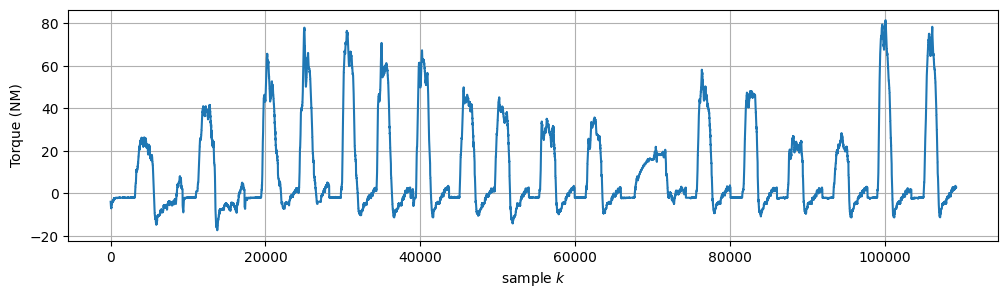

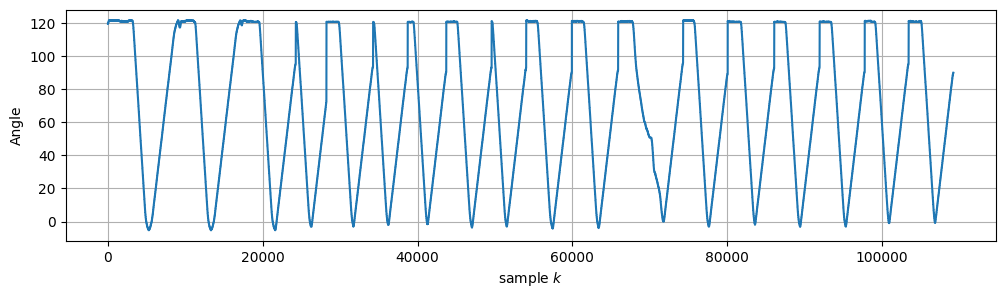

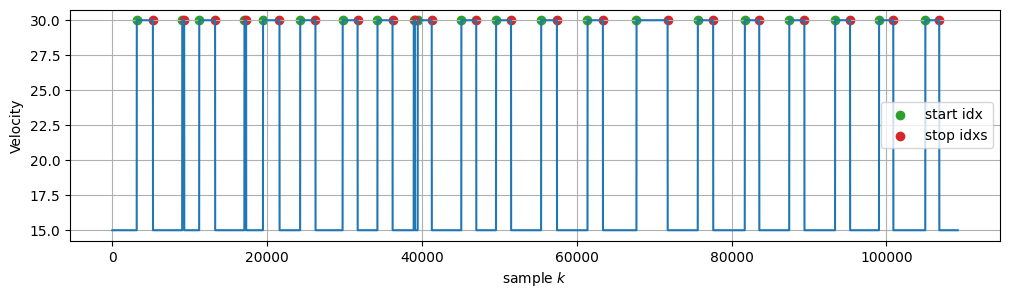

In [5]:
isoforce_iso = IsoforceIso(DF)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
isoforce_iso.plot_velocity()

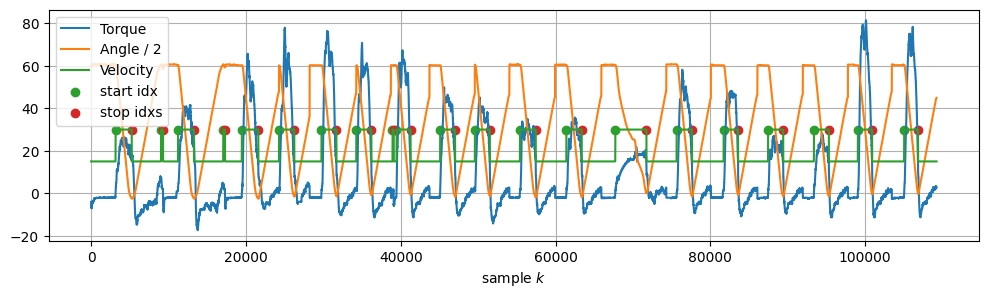

In [6]:
isoforce_iso.plot_data()

20.0
4.0
31.0
3.0
40.0
45.0
51.0
45.0
1.0
48.0
36.0
32.0
26.0
25.0
14.0
37.0
38.0
20.0
19.0
56.0
52.0


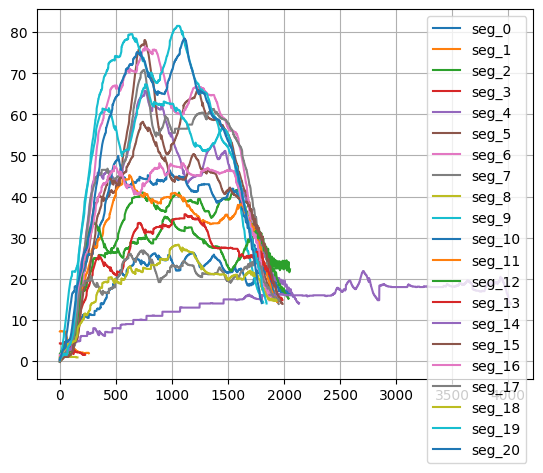

In [7]:
for key in isoforce_iso.torque_segments.keys():
    plt.plot(isoforce_iso.torque_segments[key], label=key)
    print(np.round(np.mean(isoforce_iso.torque_segments[key])))
plt.legend()
plt.grid()
plt.show()

**EIT Sciospec raw**

In [6]:
part_path.print_info()

Fund participant data:

Head directory: self.path='measurements/Participant_test1/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='measurements/Participant_test1/Test_1_JO_raw_data_10012025154959.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='measurements/Participant_test1/Isokinetic_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='measurements/Participant_test1/EIT_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='measurements/Participant_test1/EIT_raw/20250113 09.24.18/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='measurements/Participant_test1/EIT_processed/'


In [7]:
try:
    os.mkdir(part_path.s_path_eit)
    process_sciospec_eit(part_path)
except BaseException:
    print("Directory already exists.")

Directory already exists.


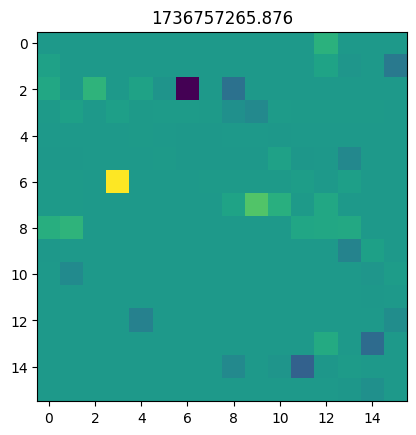

In [8]:
tmp = np.load(part_path.s_path_eit + "setup_00002.npz", allow_pickle=True)
tmp_2 = np.load(part_path.s_path_eit + "setup_00003.npz", allow_pickle=True)
tmp.files

plt.title(tmp["timestamp"])
plt.imshow(tmp["eit"].real - tmp_2["eit"].real)
plt.show()

**Isoforce Python raw**

In [9]:
part_path.isoforce_py_raw

'measurements/Participant_test1/Isokinetic_raw/'

In [15]:
import re
from datetime import datetime, timedelta, timezone

# Initialize lists to store aggregated data
all_position = list()  # channel 1
all_torque = list()  # channel 2
all_speed = list()  # channel 3
all_time = list()


# Function to extract timestamp and sample number from filename
def extract_timestamp_and_sample(filename):
    match = re.search(r"_(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_(\d+)\.npz$", filename)
    if match:
        timestamp_str = match.group(1)  # Extract the timestamp
        sample_number = int(match.group(2))  # Extract the sample number
        timestamp = datetime.strptime(
            timestamp_str, "%Y-%m-%d_%H-%M-%S"
        )  # Convert to datetime
        return (timestamp, sample_number)
    return (None, None)


file_list = sorted(
    [f for f in os.listdir(part_path.isoforce_py_raw) if f.endswith(".npz")],
    key=lambda f: (extract_timestamp_and_sample(f)),
)

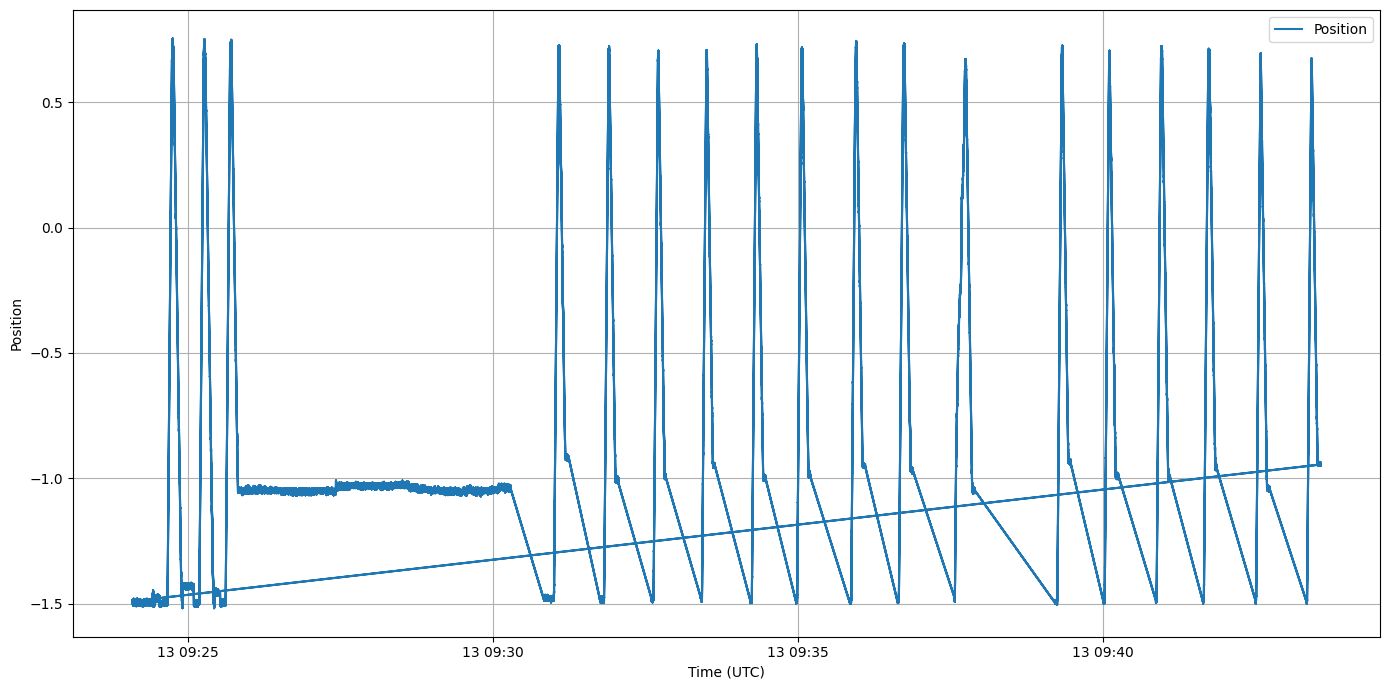

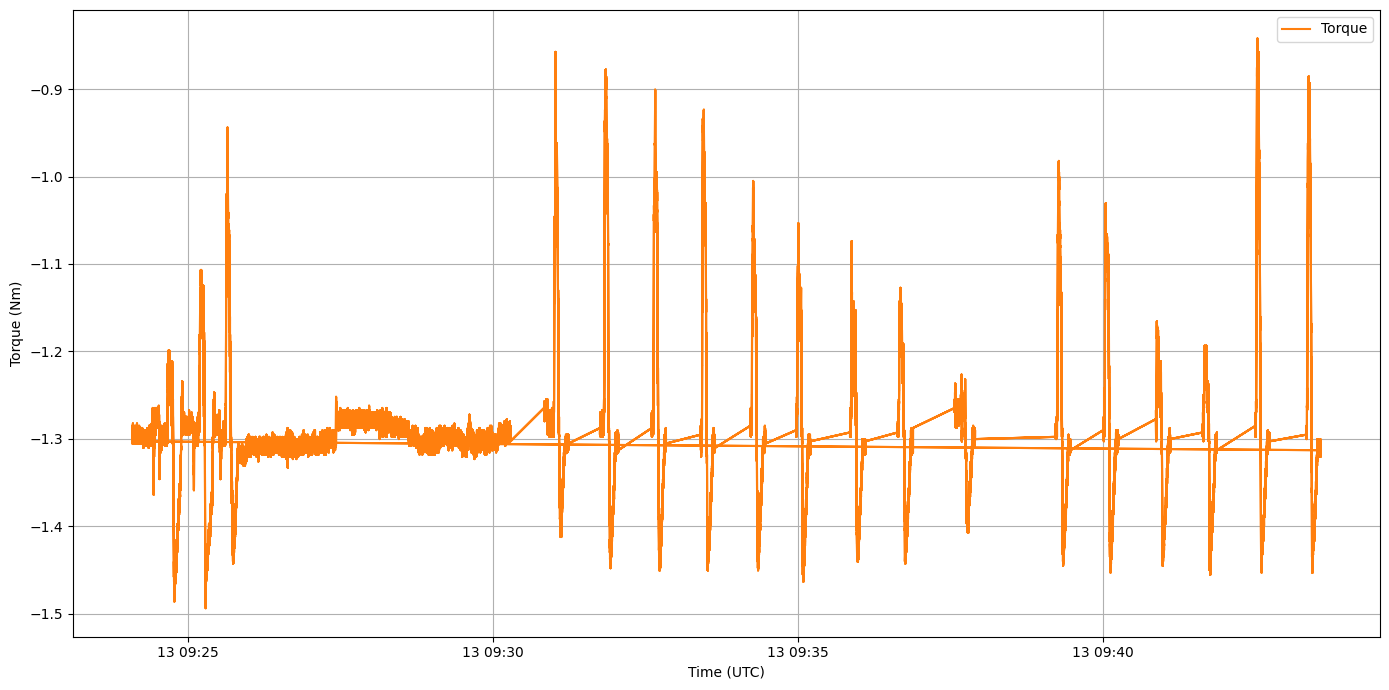

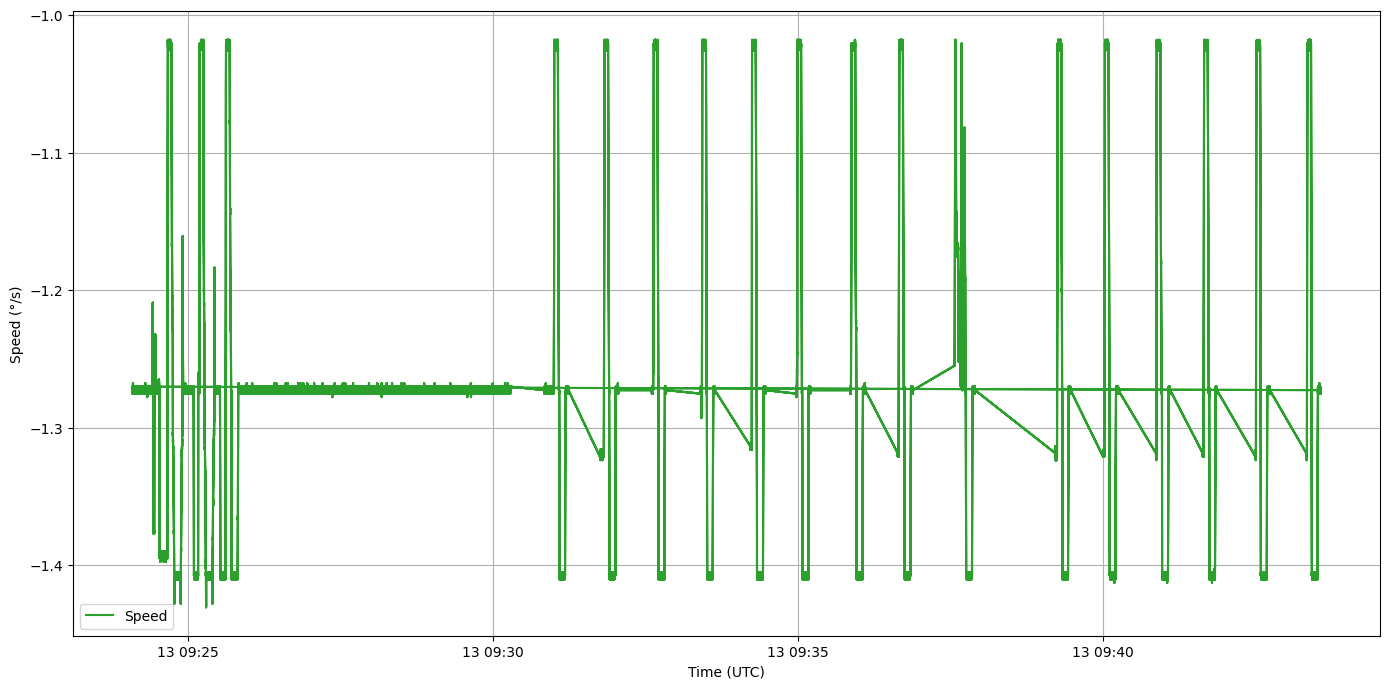

In [18]:
last_file_for_timestamp = {}

for file_name in file_list:
    timestamp, sample_number = extract_timestamp_and_sample(file_name)
    last_file_for_timestamp[timestamp] = file_name  # Overwrite with the latest file

for timestamp, last_file in last_file_for_timestamp.items():
    file_path = os.path.join(part_path.isoforce_py_raw, last_file)
    data = np.load(file_path, allow_pickle=True)

    # Extract the data for the last file of this timestamp
    ch_1, ch_2, ch_3 = data["data"]
    assert len(ch_1) == len(ch_2) == len(ch_3)

    timestamps_start = data["timestamps_start"]
    timestamps = data["timestamps_current"]
    sampling_rate = data["sampling_rate"]

    # Expand timestamps for the last sample file
    timestamps_expanded = [
        timestamp + timedelta(seconds=(i / sampling_rate)) for i in range(len(ch_1))
    ]

    # Append the torque and time data
    all_position.extend(ch_1)
    all_torque.extend(ch_2)
    all_speed.extend(ch_3)
    all_time.extend(timestamps_expanded)

# Plot the aggregated torque over time
plt.figure(figsize=(14, 7))
plt.plot(all_time, all_position, label="Position", color="C0")
plt.xlabel("Time (UTC)")
plt.ylabel("Position")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(all_time, all_torque, label="Torque", color="C1")
plt.xlabel("Time (UTC)")
plt.ylabel("Torque (Nm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(all_time, all_speed, label="Speed", color="C2")
plt.xlabel("Time (UTC)")
plt.ylabel("Speed (°/s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()